In [30]:
import sys
import os
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC

from Utils.data_utils import load_preprocessed_data_from_folder



In [2]:
sys.path.append(os.path.abspath(os.path.join(os.path.dirname('Utils'), '..')))

# Load the data from the CSV file into a pandas DataFrame
data = load_preprocessed_data_from_folder()

data

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,0.475227,0.571139,0.336096,0.543891,0.680385,0.669439,0.313402,0.699753,0.286091,0.0
1,0.265434,0.297400,0.300611,0.491839,0.676487,0.719411,0.497319,0.450999,0.576793,0.0
2,0.578509,0.641311,0.321619,0.698543,0.558823,0.414652,0.562017,0.532866,0.303637,0.0
3,0.594055,0.605536,0.356244,0.603314,0.647347,0.317880,0.622089,0.808065,0.601015,0.0
4,0.649445,0.484851,0.289922,0.484900,0.514545,0.379337,0.358555,0.253606,0.496327,0.0
...,...,...,...,...,...,...,...,...,...,...
7987,0.447629,0.509255,0.447512,0.688031,0.550855,0.167116,0.424914,0.476354,0.416496,1.0
7988,0.569804,0.477218,0.259559,0.537921,0.524618,0.188404,0.411696,0.596761,0.431539,1.0
7989,0.389444,0.550602,0.231928,0.574340,0.480976,0.503006,0.452893,0.767213,0.707229,1.0
7990,0.488616,0.451909,0.582194,0.416325,0.478834,0.514122,0.498098,0.549356,0.537085,1.0


In [3]:
TEST_SIZE = 0.2
NUM_FOLDS = 5

train_df, test_df = train_test_split(data, test_size=TEST_SIZE)
train_df, test_df

(            ph  Hardness    Solids  Chloramines   Sulfate  Conductivity  \
 6110  0.662256  0.821893  0.633194     0.602269  0.326921      0.565057   
 1565  0.442232  0.667015  0.483652     0.315389  0.338903      0.537668   
 4638  0.581677  0.489679  0.169977     0.489694  0.643823      0.430284   
 7901  0.583852  0.700316  0.179735     0.406081  0.681169      0.658095   
 7388  0.414645  0.481840  0.617068     0.457514  0.585565      0.416359   
 ...        ...       ...       ...          ...       ...           ...   
 6795  0.434597  0.391159  0.443126     0.584355  0.659939      0.446798   
 5144  0.493181  0.230089  0.536239     0.177633  0.680018      0.412279   
 2161  0.297222  0.487154  0.418585     0.640519  0.477911      0.380878   
 2495  0.444014  0.493510  0.202853     0.737832  0.542199      0.526286   
 1731  0.433578  0.413861  0.434168     0.461020  0.541751      0.532269   
 
       Organic_carbon  Trihalomethanes  Turbidity  Potability  
 6110        0.528010 

In [4]:
train_x = train_df.drop('Potability', axis=1)
train_y = train_df['Potability']

test_x = test_df.drop('Potability', axis=1)
test_y = test_df['Potability']

In [6]:
oModel = SVC()
oModel.fit(train_x, train_y)

print(f'SVC test accuracy: {oModel.score(test_x, test_y):0.2%}')

SVC test accuracy: 71.86%


In [7]:
vC = [0.001, 0.01, 0.1, 1, 10]
vGamma = ['scale', 'auto']
param_grid = [
    {'kernel': ['poly'], 'C': vC, 'degree': [2, 3], 'gamma': vGamma},
    {'kernel': ['rbf'], 'C': vC, 'gamma': vGamma, },
    {'kernel': ['sigmoid'], 'C': vC, 'gamma': vGamma, },
]

grid_search = GridSearchCV(SVC(), param_grid, scoring='f1', verbose=4, cv=NUM_FOLDS, n_jobs=-1)
grid_search.fit(train_x, train_y)

print(f'SVC test accuracy: {grid_search.score(test_x, test_y):0.2%}')

Fitting 5 folds for each of 40 candidates, totalling 200 fits
SVC test accuracy: 77.36%


In [8]:
best_model = grid_search.best_estimator_
print(f'Best model: {best_model}, best params: {grid_search.best_params_}')

print(f'Best model score: {best_model.score(test_x, test_y):0.2%}')

Best model: SVC(C=10), best params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best model score: 77.92%


In [9]:
C_values = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]
f1_scores_rbf = []
for C in C_values:
    print(f'start for C = {C}')
    svc = SVC(kernel=grid_search.best_params_['kernel'], C=C,gamma=grid_search.best_params_['gamma'])
    svc.fit(train_x, train_y)
    y_pred = svc.predict(test_x)
    f1 = f1_score(test_y, y_pred)
    f1_scores_rbf.append(f1)
    print(f'end for C = {C}')

start for C = 0.0001
end for C = 0.0001
start for C = 0.0005
end for C = 0.0005
start for C = 0.001
end for C = 0.001
start for C = 0.005
end for C = 0.005
start for C = 0.01
end for C = 0.01
start for C = 0.05
end for C = 0.05
start for C = 0.1
end for C = 0.1
start for C = 0.5
end for C = 0.5
start for C = 1
end for C = 1
start for C = 5
end for C = 5
start for C = 10
end for C = 10
start for C = 50
end for C = 50
start for C = 100
end for C = 100
start for C = 500
end for C = 500
start for C = 1000
end for C = 1000


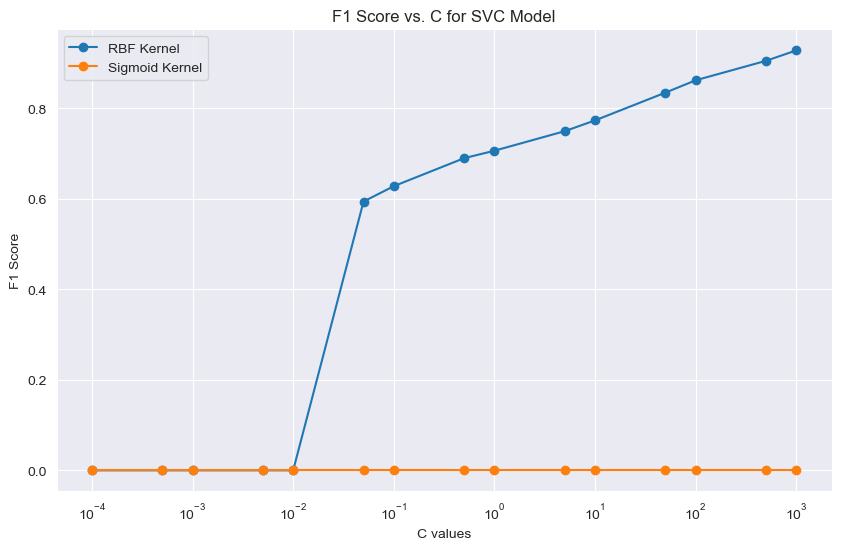

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(C_values, f1_scores_rbf, marker='o', label='RBF Kernel')
plt.title('F1 Score vs. C for SVC Model')
plt.xlabel('C values')
plt.ylabel('F1 Score')
plt.xscale('log')
plt.grid(True)
plt.legend()
plt.show()

In [12]:
C_values = np.linspace(0.1, 10000, 15)
f1_scores_rbf = []
for C in C_values:
    print(f'start for C = {C}')
    svc = SVC(kernel=grid_search.best_params_['kernel'], C=C,gamma=grid_search.best_params_['gamma'])
    svc.fit(train_x, train_y)
    y_pred = svc.predict(test_x)
    f1 = f1_score(test_y, y_pred)
    f1_scores_rbf.append(f1)
    print(f'end for C = {C}')

start for C = 0.1
end for C = 0.1
start for C = 714.3785714285714
end for C = 714.3785714285714
start for C = 1428.6571428571426
end for C = 1428.6571428571426
start for C = 2142.935714285714
end for C = 2142.935714285714
start for C = 2857.2142857142853
end for C = 2857.2142857142853
start for C = 3571.492857142857
end for C = 3571.492857142857
start for C = 4285.771428571428
end for C = 4285.771428571428
start for C = 5000.05
end for C = 5000.05
start for C = 5714.328571428571
end for C = 5714.328571428571
start for C = 6428.607142857142
end for C = 6428.607142857142
start for C = 7142.885714285714
end for C = 7142.885714285714
start for C = 7857.164285714285
end for C = 7857.164285714285
start for C = 8571.442857142856
end for C = 8571.442857142856
start for C = 9285.721428571427
end for C = 9285.721428571427
start for C = 10000.0
end for C = 10000.0


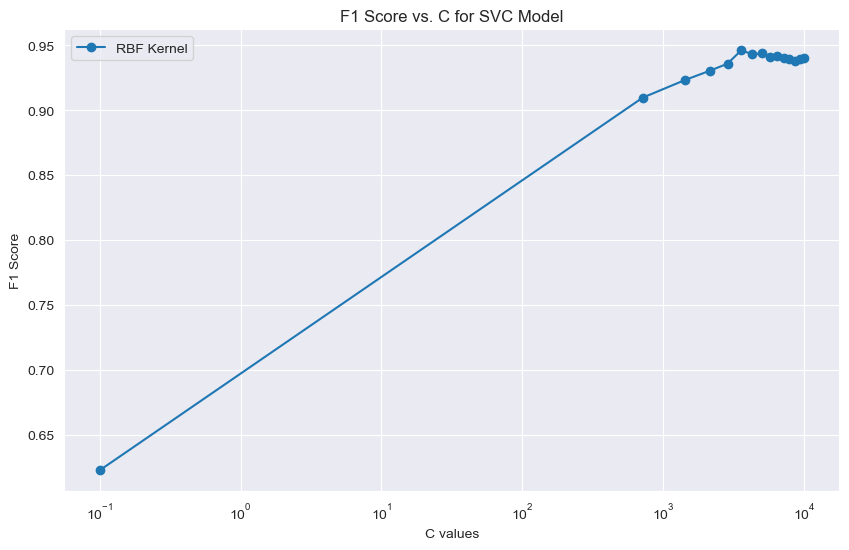

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(C_values, f1_scores_rbf, marker='o', label='RBF Kernel')
plt.title('F1 Score vs. C for SVC Model')
plt.xlabel('C values')
plt.ylabel('F1 Score')
plt.xscale('log')
plt.grid(True)
plt.legend()
plt.show()

In [14]:
C_values = np.linspace(4000, 8000, 10)
f1_scores_rbf = []
for C in C_values:
    print(f'start for C = {C}')
    svc = SVC(kernel=grid_search.best_params_['kernel'], C=C,gamma=grid_search.best_params_['gamma'])
    svc.fit(train_x, train_y)
    y_pred = svc.predict(test_x)
    f1 = f1_score(test_y, y_pred)
    f1_scores_rbf.append(f1)
    print(f'end for C = {C}')

start for C = 4000.0
end for C = 4000.0
start for C = 4444.444444444444
end for C = 4444.444444444444
start for C = 4888.888888888889
end for C = 4888.888888888889
start for C = 5333.333333333334
end for C = 5333.333333333334
start for C = 5777.777777777777
end for C = 5777.777777777777
start for C = 6222.222222222223
end for C = 6222.222222222223
start for C = 6666.666666666667
end for C = 6666.666666666667
start for C = 7111.111111111111
end for C = 7111.111111111111
start for C = 7555.555555555556
end for C = 7555.555555555556
start for C = 8000.0
end for C = 8000.0


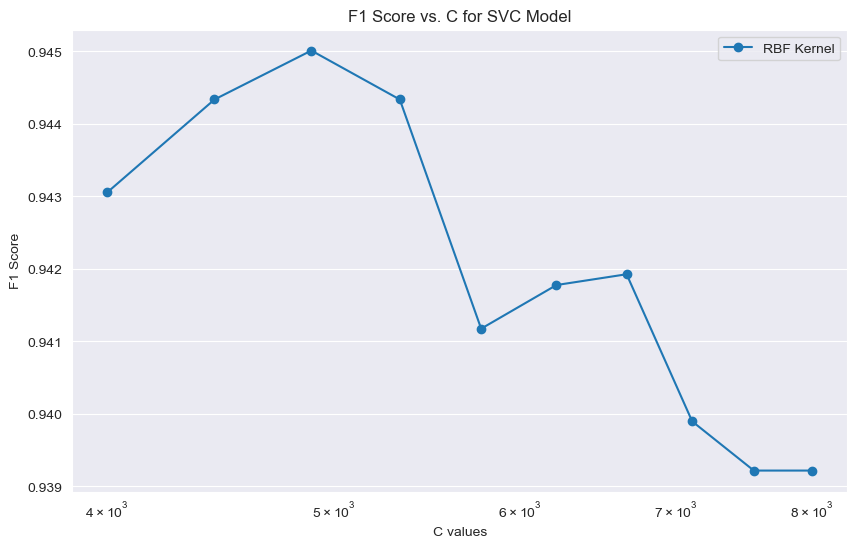

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(C_values, f1_scores_rbf, marker='o', label='RBF Kernel')
plt.title('F1 Score vs. C for SVC Model')
plt.xlabel('C values')
plt.ylabel('F1 Score')
plt.xscale('log')
plt.grid(True)
plt.legend()
plt.show()

In [16]:
C_values = np.linspace(4500, 5000, 10)
f1_scores_rbf = []
for C in C_values:
    print(f'start for C = {C}')
    svc = SVC(kernel=grid_search.best_params_['kernel'], C=C,gamma=grid_search.best_params_['gamma'])
    svc.fit(train_x, train_y)
    y_pred = svc.predict(test_x)
    f1 = f1_score(test_y, y_pred)
    f1_scores_rbf.append(f1)
    print(f'end for C = {C}')

start for C = 4500.0
end for C = 4500.0
start for C = 4555.555555555556
end for C = 4555.555555555556
start for C = 4611.111111111111
end for C = 4611.111111111111
start for C = 4666.666666666667
end for C = 4666.666666666667
start for C = 4722.222222222223
end for C = 4722.222222222223
start for C = 4777.777777777777
end for C = 4777.777777777777
start for C = 4833.333333333333
end for C = 4833.333333333333
start for C = 4888.888888888889
end for C = 4888.888888888889
start for C = 4944.444444444444
end for C = 4944.444444444444
start for C = 5000.0
end for C = 5000.0


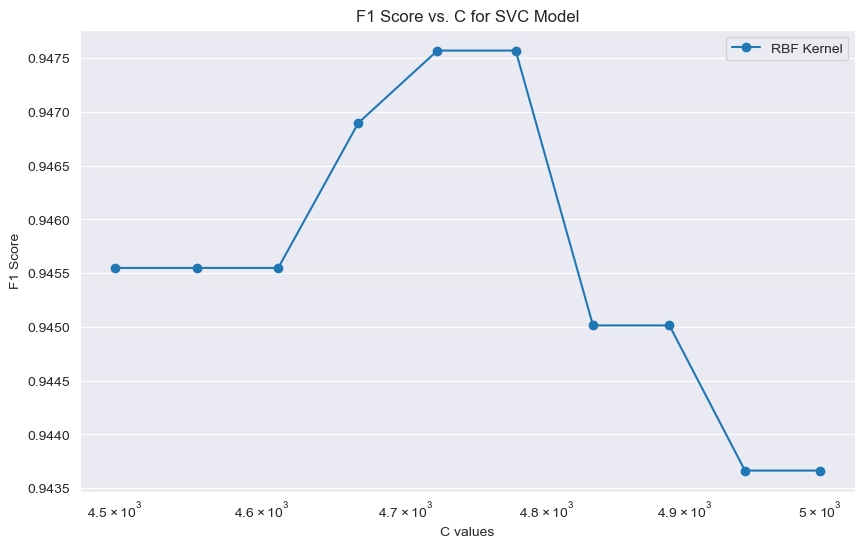

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(C_values, f1_scores_rbf, marker='o', label='RBF Kernel')
plt.title('F1 Score vs. C for SVC Model')
plt.xlabel('C values')
plt.ylabel('F1 Score')
plt.xscale('log')
plt.grid(True)
plt.legend()
plt.show()

In [26]:
C_values = np.linspace(4703, 4705, 3)
f1_scores_rbf = []
for C in C_values:
    print(f'start for C = {C}')
    svc = SVC(kernel=grid_search.best_params_['kernel'], C=C,gamma=grid_search.best_params_['gamma'])
    svc.fit(train_x, train_y)
    y_pred = svc.predict(test_x)
    f1 = f1_score(test_y, y_pred)
    f1_scores_rbf.append(f1)
    print(f'end for C = {C}')

start for C = 4703.0
end for C = 4703.0
start for C = 4704.0
end for C = 4704.0
start for C = 4705.0
end for C = 4705.0


end for C = 4705.0


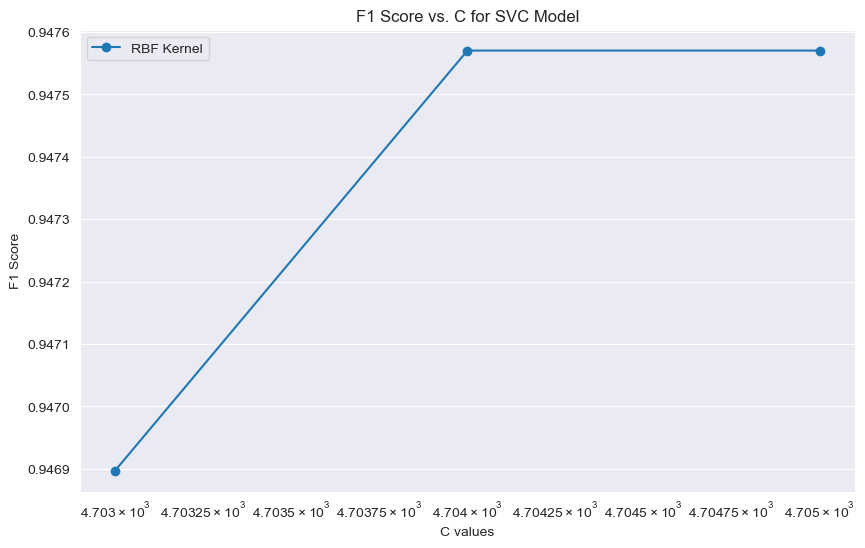

In [27]:
    print(f'end for C = {C}')
plt.figure(figsize=(10, 6))
plt.plot(C_values, f1_scores_rbf, marker='o', label='RBF Kernel')
plt.title('F1 Score vs. C for SVC Model')
plt.xlabel('C values')
plt.ylabel('F1 Score')
plt.xscale('log')
plt.grid(True)
plt.legend()
plt.show()

In [43]:
ideal_svc = SVC(kernel=grid_search.best_params_['kernel'], C=10,gamma=grid_search.best_params_['gamma'])
ideal_svc.fit(train_x, train_y)
ideal_y_pred = ideal_svc.predict(test_x)
too_big_ideal_svc = SVC(kernel=grid_search.best_params_['kernel'], C=4704,gamma=grid_search.best_params_['gamma'])
too_big_ideal_svc.fit(train_x, train_y)
too_big_ideal_y_pred = too_big_ideal_svc.predict(test_x)

In [44]:
from sklearn.metrics import accuracy_score

train_accuracy = accuracy_score(test_y, ideal_y_pred)
test_accuracy = accuracy_score(test_y, too_big_ideal_y_pred)

print("Train Accuracy:", train_accuracy)
print("Too big C Train Accuracy:", test_accuracy)

Train Accuracy: 0.7792370231394622
Too big C Train Accuracy: 0.9487179487179487


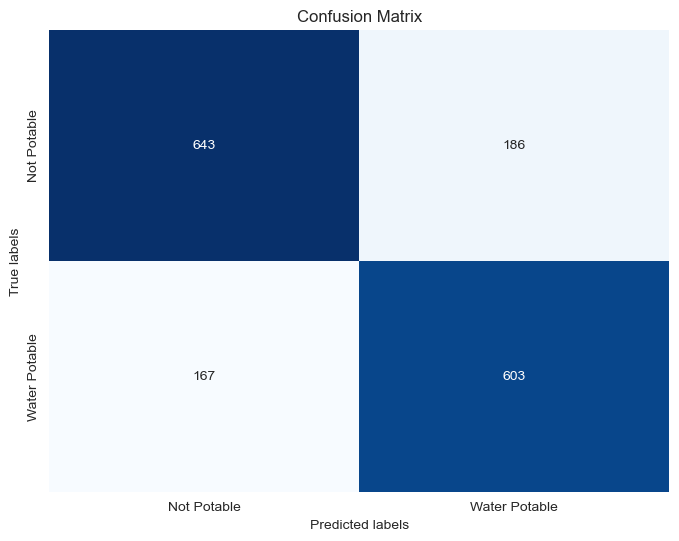

In [45]:
labels = ['Not Potable','Water Potable']
cm = confusion_matrix(test_y, ideal_y_pred,labels=[0, 1])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

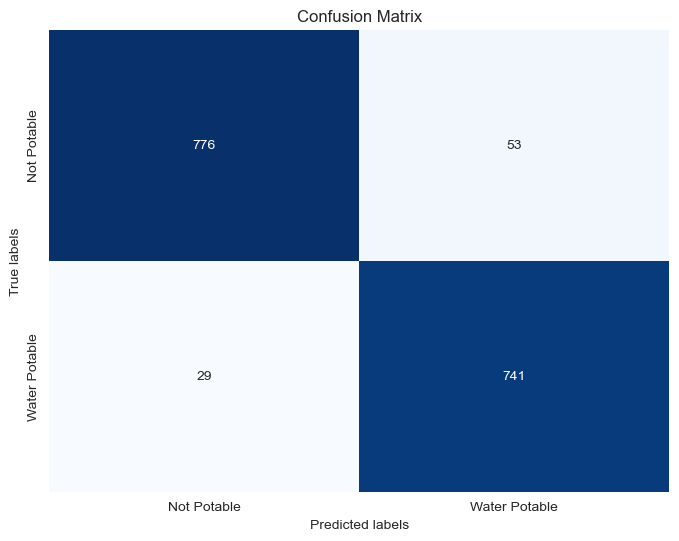

In [46]:
labels = ['Not Potable','Water Potable']
cm = confusion_matrix(test_y, too_big_ideal_y_pred,labels=[0, 1])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [47]:
calibrated_svc = CalibratedClassifierCV(ideal_svc, cv=NUM_FOLDS)
calibrated_svc.fit(train_x, train_y)

print(f'Calibrated SVC test accuracy: {calibrated_svc.score(test_x, test_y):0.2%}')

Calibrated SVC test accuracy: 77.36%


In [51]:
too_big_calibrated_svc = CalibratedClassifierCV(too_big_ideal_svc, cv=NUM_FOLDS)
too_big_calibrated_svc.fit(train_x, train_y)

print(f'Too big C Calibrated SVC test accuracy: {too_big_calibrated_svc.score(test_x, test_y):0.2%}')

Too big C Calibrated SVC test accuracy: 93.31%


In [52]:
calibrated_svc.predict_proba(test_x)

array([[0.06594904, 0.93405096],
       [0.11582019, 0.88417981],
       [0.18254214, 0.81745786],
       ...,
       [0.52939967, 0.47060033],
       [0.14243503, 0.85756497],
       [0.04172924, 0.95827076]])

In [53]:
too_big_calibrated_svc.predict_proba(test_x)

array([[0.40513001, 0.59486999],
       [0.19001402, 0.80998598],
       [0.13333348, 0.86666652],
       ...,
       [0.47408531, 0.52591469],
       [0.24328637, 0.75671363],
       [0.0010298 , 0.9989702 ]])

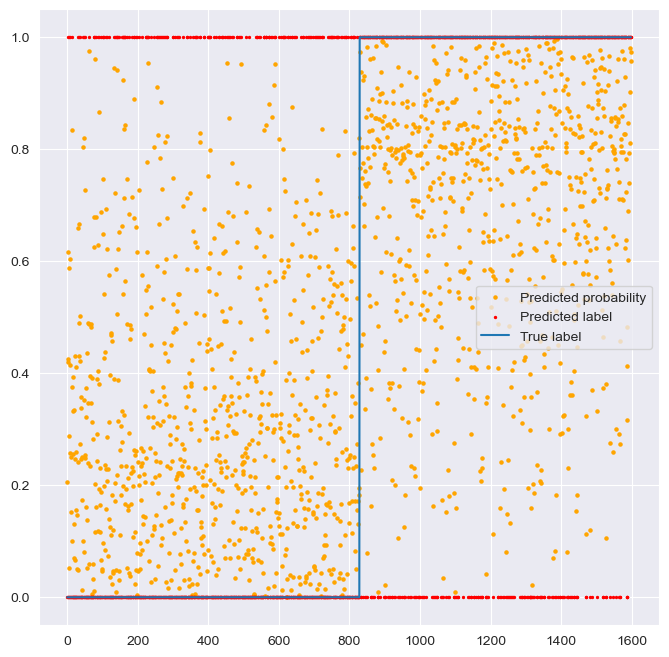

In [54]:
# Create a zipped array of sample index, predicted proability and true label
results = np.column_stack((calibrated_svc.predict_proba(test_x)[:, 1], calibrated_svc.predict(test_x), test_y))

# Sort by true label
results = results[results[:, 2].argsort()]

# Plot the predicted probabilities & true labels

plt.figure(figsize=(8, 8))
plt.scatter(range(len(results)), results[:, 0], label='Predicted probability', c='orange', s=5)
plt.scatter(range(len(results)), results[:, 1], label='Predicted label', c='red', s=2)
plt.plot(results[:, 2], label='True label')
plt.legend()

plt.show()

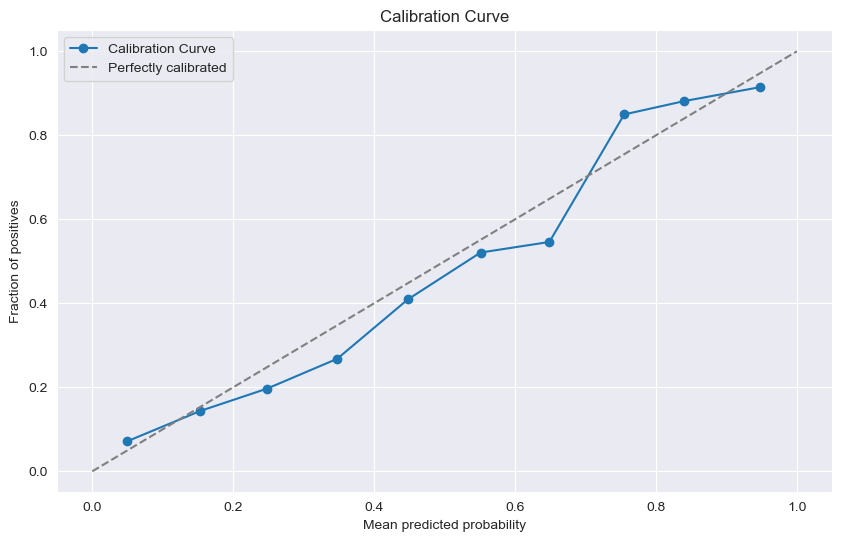

In [55]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(test_y, calibrated_svc.predict_proba(test_x)[:, 1], n_bins=10)

plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()

In [58]:
too_big_y_proba = too_big_calibrated_svc.predict_proba(test_x)[:, 1]
too_big_y_pred = too_big_calibrated_svc.predict(test_x)

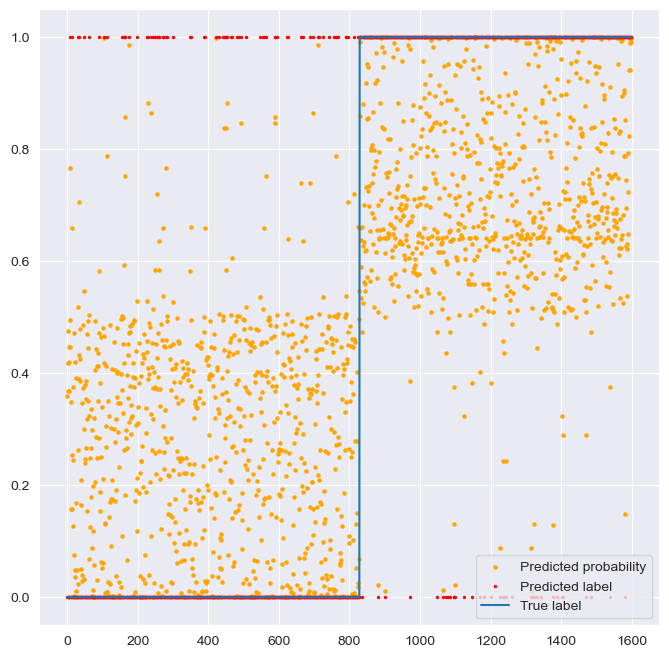

In [59]:
# Create a zipped array of sample index, predicted proability and true label
results = np.column_stack((too_big_y_proba, too_big_y_pred, test_y))

# Sort by true label
results = results[results[:, 2].argsort()]

# Plot the predicted probabilities & true labels

plt.figure(figsize=(8, 8))
plt.scatter(range(len(results)), results[:, 0], label='Predicted probability', c='orange', s=5)
plt.scatter(range(len(results)), results[:, 1], label='Predicted label', c='red', s=2)
plt.plot(results[:, 2], label='True label')
plt.legend()

plt.show()

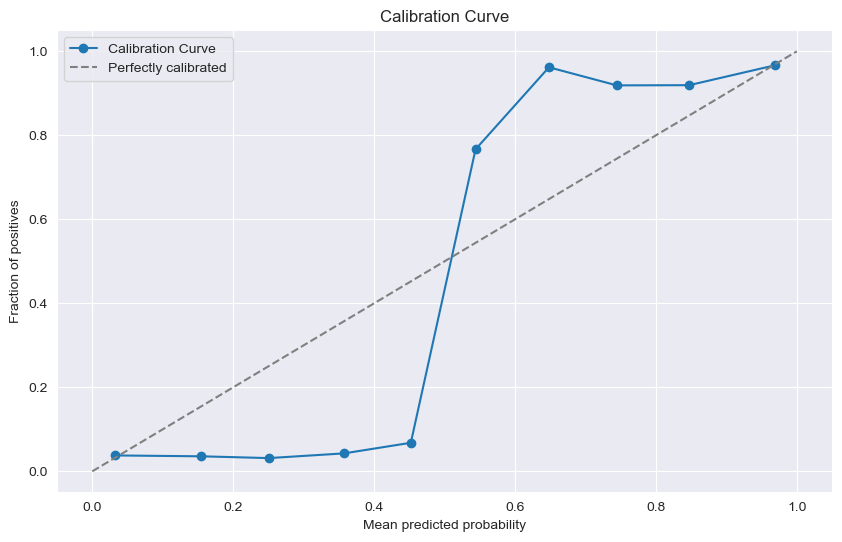

In [60]:
plt.show()
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(test_y, too_big_y_proba, n_bins=10)

plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()